In [ ]:
!pip install google-cloud-aiplatform google-cloud-storage
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Conv1D, MaxPooling1D, Dropout, Flatten, Attention, Input
from tensorflow.keras.layers import TimeDistributed
import pandas as pd
from tensorflow.keras.optimizers import Adam
from matplotlib import pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import root_mean_squared_error
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
import os
from datetime import datetime,timedelta
import gc
import psutil
from tensorflow import keras

In [ ]:
from google.cloud import storage

BUCKET_NAME = "gold_predictions_web"  # เปลี่ยนเป็นชื่อ Bucket ของคุณ

client = storage.Client()
bucket = client.bucket(BUCKET_NAME)
print(f"เชื่อมต่อกับ GCS Bucket: {BUCKET_NAME}")

เชื่อมต่อกับ GCS Bucket: gold_predictions_web


In [ ]:
import requests
nowDate=datetime.now()
startTime=f'{nowDate.year-10}-{nowDate.month}-{nowDate.day}'
endTime=f'{nowDate.year}-{nowDate.month}-{nowDate.day}'
startTime_1=f'{nowDate.day}-{nowDate.month}-{nowDate.year-10}'
endTime_1=f'{nowDate.day}-{nowDate.month}-{nowDate.year}'
url_currency = f"https://gold-predictions.duckdns.org/currency/get/?start={startTime}&end={endTime}&cache=False"
url_Gold_usd = f"https://gold-predictions.duckdns.org/finnomenaGold/get-gold-data/?db_choice=1&start={startTime_1}&end={endTime_1}&cache=False"
url_Gold_thb = f"https://gold-predictions.duckdns.org/finnomenaGold/get-gold-data/?db_choice=0&start={startTime_1}&end={endTime_1}&cache=False"
# เรียก API และดึงข้อมูล
response = requests.get(url_currency)

# ตรวจสอบว่าการเรียก API สำเร็จหรือไม่
if response.status_code == 200:
    data_currency = response.json()  # แปลงข้อมูลเป็น JSON
    data_list = data_currency["data"]
    df_currency = pd.DataFrame(data_list)  # สร้าง DataFrame
    print(df_currency.tail())  # แสดงตัวอย่างข้อมูล
else:
    print(f"Error: {response.status_code}")

response = requests.get(url_Gold_usd)

# ตรวจสอบว่าการเรียก API สำเร็จหรือไม่
if response.status_code == 200:
    data_Gold_usd = response.json()  # แปลงข้อมูลเป็น JSON
    data_list = data_Gold_usd["data"]
    df_Gold_usd = pd.DataFrame(data_list)  # สร้าง DataFrame
    print(df_Gold_usd.tail())  # แสดงตัวอย่างข้อมูล
else:
    print(f"Error: {response.status_code}")

response = requests.get(url_Gold_thb)

# ตรวจสอบว่าการเรียก API สำเร็จหรือไม่
if response.status_code == 200:
    data_Gold_thb = response.json()  # แปลงข้อมูลเป็น JSON
    data_list = data_Gold_thb["data"]
    df_Gold_thb = pd.DataFrame(data_list)  # สร้าง DataFrame
    print(df_Gold_thb.tail())  # แสดงตัวอย่างข้อมูล
else:
    print(f"Error: {response.status_code}")

df_currency=df_currency[['date','price']]
df_currency.columns = ['Date', 'price_exchange']

df_Gold_thb=df_Gold_thb[['timestamp','price']]
df_Gold_thb = df_Gold_thb.copy()
df_Gold_thb['timestamp'] = df_Gold_thb['timestamp'].apply(lambda x: x // 1000 if x > 10**12 else x)
df_Gold_thb['timestamp'] = pd.to_datetime(df_Gold_thb['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
df_Gold_thb['timestamp'] = df_Gold_thb['timestamp'].dt.strftime('%d/%m/%Y')
df_Gold_thb.columns = ['Date', 'Thai_Gold']

df_Gold_usd=df_Gold_usd[['timestamp','close_price']]
df_Gold_usd = df_Gold_usd.copy()
df_Gold_usd['timestamp'] = df_Gold_usd['timestamp'].apply(lambda x: x // 1000 if x > 10**12 else x)
df_Gold_usd['timestamp'] = pd.to_datetime(df_Gold_usd['timestamp'], unit='s').dt.tz_localize('UTC').dt.tz_convert('Asia/Bangkok')
df_Gold_usd['timestamp'] = df_Gold_usd['timestamp'].dt.strftime('%d/%m/%Y')
df_Gold_usd.columns = ['Date', 'Xau']


# รวม DataFrame ทั้งสามโดยใช้ date เป็นคีย์อ้างอิง
df_currency['Date'] = pd.to_datetime(df_currency['Date'], format='%Y-%m-%d').dt.normalize()
df_Gold_thb['Date'] = pd.to_datetime(df_Gold_thb['Date'], format='%d/%m/%Y').dt.normalize()
df_Gold_usd['Date'] = pd.to_datetime(df_Gold_usd['Date'], format='%d/%m/%Y').dt.normalize()
merged_df = (
    df_Gold_thb
    .merge(df_Gold_usd, on='Date', how='outer')
    .merge(df_currency, on='Date', how='outer')
)
merged_df = (
    merged_df
    .sort_values('Date')
    .groupby('Date', as_index=False)
    .first()  # เอาแถวแรกของแต่ละวัน
)
print(df_currency.dtypes)
print(df_Gold_thb.dtypes)
print(df_Gold_usd.dtypes)

merged_df[['Xau']] = merged_df[['Xau']].shift(1)
merged_df['Xau'] = merged_df['Xau'].ffill()
merged_df.dropna(inplace=True)
merged_df.to_csv('acvs.csv')
dupes = merged_df[merged_df.duplicated('Date', keep=False)]
print(f"จำนวนวันที่ซ้ำ: {len(dupes)}")
print(dupes.sort_values('Date'))

          id        date  price   open   high    low  percent  diff
6882  194970  2025-04-19  33.39  33.35  33.45  33.32     0.11  0.04
6883  194971  2025-04-20  33.38  33.39  33.44  33.31    -0.04 -0.01
6884  194972  2025-04-21  33.06  33.35  33.35  33.03    -0.96 -0.32
6885  194973  2025-04-22  33.44  33.06  33.48  33.04     1.15  0.38
6886  194974  2025-04-23  33.52  33.37  33.67  33.28     0.24  0.08
         id      timestamp    price  close_price  high_price  low_price  \
3040  90319  1744588800000  3221.80      3212.34     3245.23    3194.59   
3041  90320  1744675200000  3212.71      3250.51     3250.80    3210.20   
3042  90323  1744761600000  3252.86      3349.52     3357.01    3250.34   
3043  90325  1744848000000  3349.87      3314.93     3355.33    3276.44   
3044  90326  1745280000000  3471.10      3479.42     3499.45    3466.80   

      volume  volume_weight_avg  num_transactions      date  \
3040  3542.0          3218.3421              3542  14-04-25   
3041  3592.0   

In [ ]:
merged_df

,Date,Thai_Gold,Xau,price_exchange
1,2015-04-24,18300.0,1193.76,32.5600
2,2015-04-25,18150.0,1178.91,32.5733
4,2015-04-27,18250.0,1179.88,32.6000
5,2015-04-28,18450.0,1199.80,32.6300
6,2015-04-29,18600.0,1211.59,32.8400
...,...,...,...,...
3648,2025-04-18,52350.0,3314.93,33.3500
3649,2025-04-19,52350.0,3314.93,33.3900
3651,2025-04-21,52900.0,3314.93,33.0600
3652,2025-04-22,54550.0,3314.93,33.4400


In [ ]:
df_currency.tail()

,Date,price_exchange
6882,2025-04-19,33.39
6883,2025-04-20,33.38
6884,2025-04-21,33.06
6885,2025-04-22,33.44
6886,2025-04-23,33.52


lag=1
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step


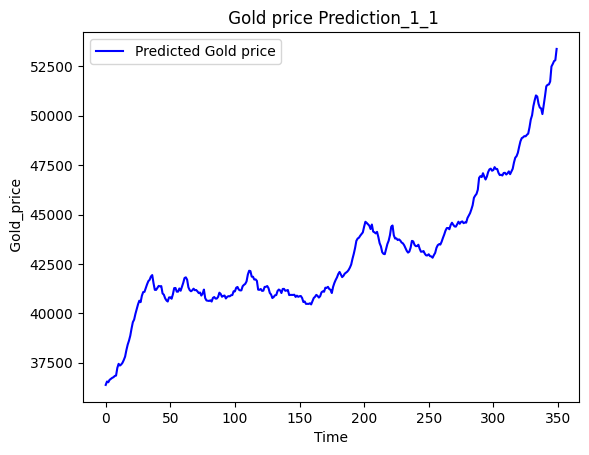

Future = 1
lag=1
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


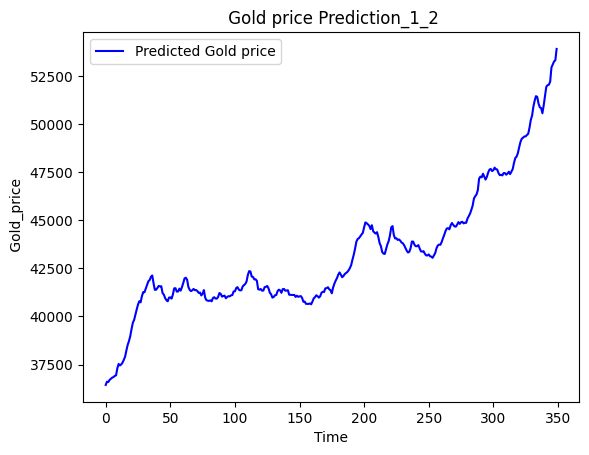

Future = 2
lag=1
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step


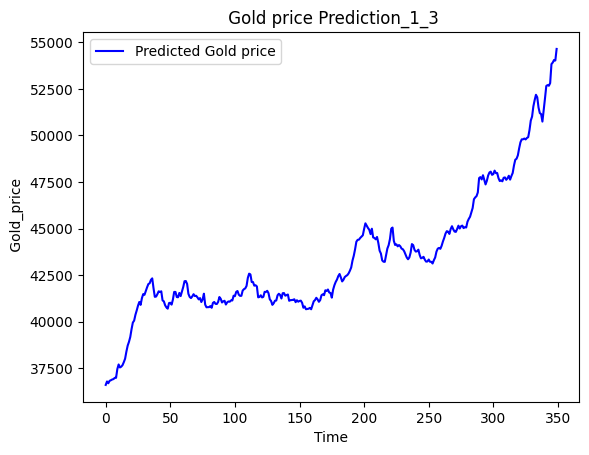

Future = 3
lag=1
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step


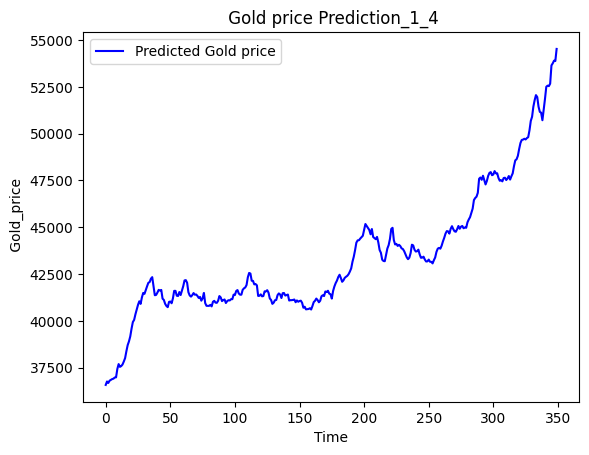

Future = 4
lag=1
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step


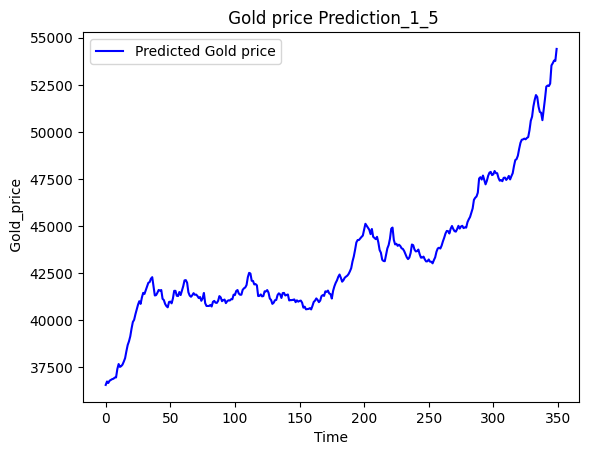

Future = 5
lag=1
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


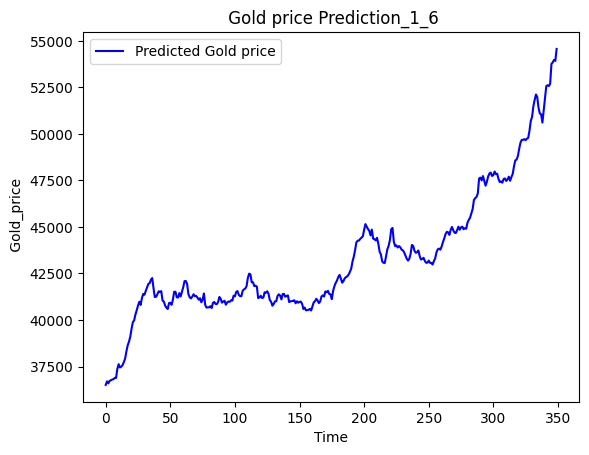

Future = 6
lag=1
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step


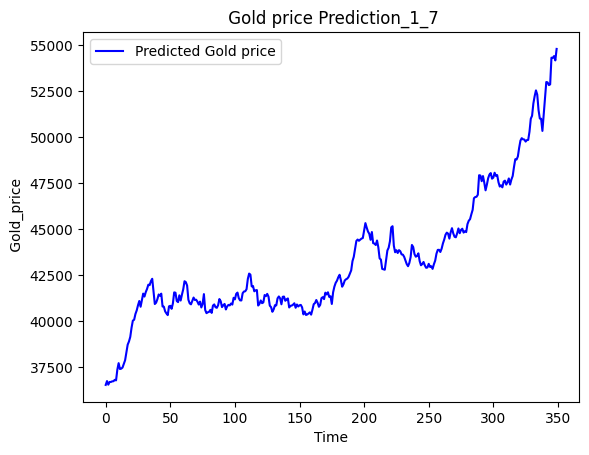

Future = 7


In [ ]:

seq = [1,1,1,1,1,1,1]
fut = [1,2,3,4,5,6,7]
movingavg=[2,2,1,1,1,1,0]
lag=[1,1,1,1,1,1,1]
dateonoff=[False,False,False,False,False,False,False]
predictArray=[]
base_path = "/content/model"
# folder_path = os.path.join(base_path, f"folder_{current_time}")
# os.makedirs(folder_path, exist_ok=True)
for indexfut in range(len(fut)):
          data = merged_df.copy()
          data['Date'] = pd.to_datetime(data['Date'], format='%d/%m/%Y')
          if dateonoff[indexfut] == True:
            data['Day_of_week'] = data['Date'].dt.day_name()
            data['Day'] = data['Date'].dt.day
            data['Month'] = data['Date'].dt.month
            data = pd.get_dummies(data, columns=['Day_of_week'], drop_first=True)

          if movingavg[indexfut] >=4:
            data['MA_20'] = data['Thai_Gold'].ewm(span=20, adjust=True).mean()
          if movingavg[indexfut] >=3:
            data['MA_14'] = data['Thai_Gold'].ewm(span=14, adjust=False).mean()
          if movingavg[indexfut] >=2:
            data['MA_10'] = data['Thai_Gold'].ewm(span=10, adjust=True).mean()
          if movingavg[indexfut] >=1:
            data['MA_7'] = data['Thai_Gold'].ewm(span=7, adjust=False).mean()
          data.dropna(inplace=True)

          target = 'Thai_Gold'
          data_clone=data
          X = data.drop(columns=['Thai_Gold','Date'])
          y = data[target].values
          for i in range(1, lag[indexfut]+1):  # สร้างย้อนหลัง 7 วัน
              print(f'lag={i}')
              X[f'Thai_Gold_Lag_{i}'] = data_clone['Thai_Gold'].shift(i)
          X = X.dropna().reset_index(drop=True)
          y=y.reshape(-1, 1)
          y = np.array(y, dtype=np.float64)
          y = y[lag[indexfut]:]
          dataframe_y=y
          dataframe_x=X
          X=X.values
          scaler_X = MinMaxScaler(feature_range=(0,1))
          scaler_y = MinMaxScaler(feature_range=(0,1))
          X = scaler_X.fit_transform(X)
          y = scaler_y.fit_transform(y)

          def createXY(DataX,n_past):
              dataX = []
              dataY = []
              for i in range(n_past, len(DataX)):
                  dataX.append(DataX[i - n_past:i,:])  # ดึงทุกฟีเจอร์ (ทุกคอลัมน์)
              return np.array(dataX)

          lookback = seq[indexfut]  # ดูย้อนหลัง 30 วัน
          X_seq= createXY(X,lookback)

          # กำหนดขนาดข้อมูล
          test_size = 350     # ขนาด Test Set
          val_size = 350      # ขนาด Validation Set
          train_size = X_seq.shape[0] - (val_size + test_size)  # ขนาด Training Set

          # แบ่งข้อมูลเป็น Training, Validation และ Test ตามลำดับเวลา
          X_train = X_seq[:train_size]
          X_val = X_seq[train_size:train_size + val_size]
          X_test = X_seq[train_size + val_size:]

          #           # ตรวจสอบขนาดของชุดข้อมูล
          # print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
          # print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
          # print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

          MODEL_NAME = f"Future_{fut[indexfut]}.keras"     # เปลี่ยนเป็นชื่อไฟล์ที่ต้องการโหลด
          DESTINATION_DIR = "models"        # โฟลเดอร์ที่ต้องการเก็บโมเดลในเครื่อง
          os.makedirs(DESTINATION_DIR, exist_ok=True)
          destination_path = os.path.join(DESTINATION_DIR, MODEL_NAME)
          blob = bucket.blob(f'models/{MODEL_NAME}')
          blob.download_to_filename(destination_path)
          # โหลดกลับมาใช้งาน
          model = keras.models.load_model(destination_path)
            # ทำการทำนาย
          prediction=model.predict(X_test)

            # แปลงผลการทำนายและค่าจริงกลับไปเป็นค่าเดิม (inverse scaling)
          predict_ori=scaler_y.inverse_transform(prediction)
          # actual_ori=scaler_y.inverse_transform(y_test)

          # plt.plot(actual_ori, color = 'red', label = 'Real  Gold Price')
          plt.plot(predict_ori, color = 'blue', label = 'Predicted Gold price')
          plt.title(f' Gold price Prediction_{seq[indexfut]}_{fut[indexfut]}')
          plt.xlabel('Time')
          plt.ylabel(' Gold_price')
          plt.legend()
          plt.show()
          if fut[indexfut] == 1:
            df_predict_1 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 2:
            df_predict_2 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 3:
            df_predict_3 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 4:
            df_predict_4 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 5:
            df_predict_5 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 6:
            df_predict_6 = pd.DataFrame(predict_ori, columns=['price'])
          if fut[indexfut] == 7:
            df_predict_7 = pd.DataFrame(predict_ori, columns=['price'])
          # df_predict.to_csv(f'Future abc = {fut[indexfut]}.csv',index=False)
          print(f"Future = {fut[indexfut]}")
          del model
          gc.collect()


In [ ]:
df_last_350 = merged_df.tail(350)

In [ ]:
df_last_350.to_csv('abc12.csv')

In [ ]:
df_last_350=df_last_350['Date'].reset_index(drop=True)

In [ ]:
df_last_350

,Date
0,2024-03-12
1,2024-03-13
2,2024-03-14
3,2024-03-15
4,2024-03-16
...,...
345,2025-04-18
346,2025-04-19
347,2025-04-21
348,2025-04-22


In [ ]:
df_predict_1

,price
0,36369.941406
1,36544.105469
2,36504.417969
3,36625.628906
4,36677.570312
...,...
345,52495.300781
346,52621.472656
347,52768.792969
348,52813.054688


In [ ]:
from datetime import datetime
import time
# ตรวจสอบว่า df_last_350 เป็น DataFrame
df_last_350 = df_last_350.to_frame() if isinstance(df_last_350, pd.Series) else df_last_350

# ตรวจสอบว่ามีคอลัมน์ price_1 ถึง price_7 หรือไม่ ถ้าไม่มีให้สร้าง
column_names = [f'price_{i+1}' for i in range(7)]
for col in column_names:
    if col not in df_last_350.columns:
        df_last_350[col] = np.nan  # ใส่ค่า NaN ถ้ายังไม่มีคอลัมน์
# แปลง df_predict_x เป็น DataFrame และรีเซ็ต index ก่อนเพิ่มเข้า df_last_350
df_last_350['price_1'] = df_predict_1['price'].reset_index(drop=True)
df_last_350['price_2'] = df_predict_2['price'].reset_index(drop=True)
df_last_350['price_3'] = df_predict_3['price'].reset_index(drop=True)
df_last_350['price_4'] = df_predict_4['price'].reset_index(drop=True)
df_last_350['price_5'] = df_predict_5['price'].reset_index(drop=True)
df_last_350['price_6'] = df_predict_6['price'].reset_index(drop=True)
df_last_350['price_7'] = df_predict_7['price'].reset_index(drop=True)

import pytz

# กำหนดโซนเวลา Indochina (ICT, UTC+7)
indochina_tz = pytz.timezone('Asia/Bangkok')

# เวลาปัจจุบันใน UTC
current_utc_time = datetime.utcnow().replace(tzinfo=pytz.utc)

# เวลาปัจจุบันใน Indochina Time (ICT, UTC+7)
current_ict_time = current_utc_time.astimezone(indochina_tz)

# แปลงเป็น Unix Timestamp (วินาที)
current_unix_time = int(time.time())

# ปรับฟอร์แมตของ Timestamp ICT ให้เป็น `YYYY-MM-DD HH:MM:SS.SSS +0700`
timestamp_ict_formatted = current_ict_time.strftime('%Y-%m-%d %H:%M:%S.%f')[:-3] + " +0700"

# เพิ่มคอลัมน์ลงใน df_last_350
df_last_350 = df_last_350.assign(
    timestamp=current_unix_time,  # Unix Timestamp (UTC)
    created_at=timestamp_ict_formatted  # Timestamp ICT แบบฟอร์แมตที่ต้องการ
)
df_last_350.rename(columns={"Date": "date"}, inplace=True)
def get_next_weekdays(start_date, count):
    result = []
    current = start_date
    while len(result) < count:
        current += pd.Timedelta(days=1)
        if current.weekday() != 6:  # ไม่ใช่วันอาทิตย์ (Sunday = 6)
            result.append(current)
    return result
for i in range(1, 8):
    df_last_350[f'date_{i}'] = df_last_350['date'].apply(lambda d: get_next_weekdays(d, 7)[i-1])
# df_last_350["date"] = pd.to_datetime(df_last_350["date"])  # แปลงเป็น datetime64
# df_last_350["timestamp"] = df_last_350["date"].astype("int64") // 10**9  # แปลงเป็น Unix timestamp (วินาที)
df_last_350["date"] = df_last_350["date"].astype(str).str[:16]  # ตัดให้ไม่เกิน 16 ตัวอักษร
for i in range(1, 8):
    df_last_350[f'date_{i}'] = df_last_350[f'date_{i}'].astype(str).str[:16]
# แสดงผลลัพธ์
df_last_350=df_last_350.iloc[[-1]]
print(df_last_350.head())
df_last_350.to_csv('abc.csv')


           date       price_1       price_2       price_3       price_4  \
349  2025-04-23  53385.535156  53908.675781  54647.054688  54528.585938   

          price_5       price_6       price_7   timestamp  \
349  54404.707031  54564.574219  54798.839844  1745432192   

                        created_at      date_1      date_2      date_3  \
349  2025-04-24 01:16:32.878 +0700  2025-04-24  2025-04-25  2025-04-26   

         date_4      date_5      date_6      date_7  
349  2025-04-28  2025-04-29  2025-04-30  2025-05-01  


In [ ]:
!pip install psycopg2-binary sqlalchemy


In [ ]:
from sqlalchemy import create_engine
# แปลง date เป็น datetime
df= pd.to_datetime(merged_df["Date"])
df = df.to_frame()

# ดึงวันที่ล่าสุดจาก DataFrame
last_date = df["Date"].max().date()  # เอาเฉพาะวันที่ (ไม่เอาเวลา)

# ดึงวันที่ปัจจุบัน
today = datetime.now().date()
if last_date == today:
# 🔹 กำหนดค่าการเชื่อมต่อ PostgreSQL
  DB_USER = "postgres"  # ชื่อผู้ใช้ PostgreSQL
  DB_PASSWORD = "postgres"  # รหัสผ่าน
  DB_HOST = "34.133.61.28"  # ปกติใช้ "localhost" หรือ IP ของเซิร์ฟเวอร์
  DB_PORT = "5432"  # พอร์ตเริ่มต้นของ PostgreSQL
  DB_NAME = "postgres"  # ชื่อฐานข้อมูล
  TABLE_NAME = "predicts_week"  # ชื่อตารางที่ต้องการ INSERT

    # 🔹 สร้าง Connection ไปยัง PostgreSQL ด้วย SQLAlchemy
  engine = create_engine(f"postgresql+psycopg2://{DB_USER}:{DB_PASSWORD}@{DB_HOST}:{DB_PORT}/{DB_NAME}")
    # df_last_350['created_at'] = pd.to_datetime(df_last_350['created_at']).dt.tz_convert('Asia/Bangkok')

    # 🔹 Insert DataFrame ลงใน PostgreSQL (ถ้าตารางไม่มีให้สร้างอัตโนมัติ)
  df_last_350.to_sql(TABLE_NAME, engine, if_exists="append", index=False)

  print(f"✅ Insert DataFrame ลงใน PostgreSQL ตาราง {TABLE_NAME} สำเร็จ!")


✅ Insert DataFrame ลงใน PostgreSQL ตาราง predicts_week สำเร็จ!
